In [1]:
import os
import pygmt
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from utils import *


# MARGIN = 1

# # SST
# copernicusmarine.subset(
#   dataset_id="METOFFICE-GLO-SST-L4-REP-OBS-SST",
#   variables=["analysed_sst"],
#   minimum_longitude=145-MARGIN,
#   maximum_longitude=165+MARGIN,
#   minimum_latitude=36-MARGIN,
#   maximum_latitude=48+MARGIN,
#   start_datetime="2011-01-01T00:00:00",
#   end_datetime="2020-12-31T00:00:00",
# )

# # CHL
# copernicusmarine.subset(
#   dataset_id="cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D",
#   variables=["CHL"],
#   minimum_longitude=145-MARGIN,
#   maximum_longitude=165+MARGIN,
#   minimum_latitude=36-MARGIN,
#   maximum_latitude=48+MARGIN,
#   start_datetime="2011-01-01T00:00:00",
#   end_datetime="2020-12-31T00:00:00",
# )

# # obs_Env
# copernicusmarine.subset(
#   dataset_id="cmems_obs-mob_glo_phy_my_0.125deg_P1M-m",
#   variables=["mlotst", "so", "to", "ugo", "vgo", "zo"],
#   minimum_longitude=145-MARGIN,
#   maximum_longitude=165+MARGIN,
#   minimum_latitude=36-MARGIN,
#   maximum_latitude=48+MARGIN,
#   start_datetime="2011-01-01T00:00:00",
#   end_datetime="2020-12-31T00:00:00",
#   minimum_depth=0,
#   maximum_depth=0,
# )

/opt/miniconda3/envs/deepQFG/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Env data

In [2]:
# Preprocess Environmental Data (SST, CHL, Multi-vars)
lat_min, lat_max = 36, 48
lon_min, lon_max = 145, 165
target_res = 0.25
target_months = [7, 8, 9, 10, 11]
new_lat = np.arange(lat_min, lat_max, target_res)
new_lon = np.arange(lon_min, lon_max, target_res)

# Load and resample SST (Monthly)
ds_sst = xr.open_dataset("./METOFFICE-GLO-SST-L4-REP-OBS-SST_analysed_sst_144.02E-165.98E_35.03N-48.97N_2011-01-01-2020-12-31.nc")
ds_sst = ds_sst.resample(time='1MS').mean()
ds_sst = ds_sst.sel(time=ds_sst.time.dt.month.isin(target_months))
ds_sst025 = ds_sst.interp(latitude=new_lat, longitude=new_lon, method='linear').rename({'analysed_sst': 'SST'})
ds_sst025['SST'] -= 273.15  # Kelvin to Celsius

# Load and resample CHL (Monthly)
ds_chl = xr.open_dataset("./cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D_CHL_144.02E-165.98E_35.02N-48.98N_2011-01-01-2020-12-31.nc")
ds_chl = ds_chl.resample(time='1MS').mean()
ds_chl = ds_chl.sel(time=ds_chl.time.dt.month.isin(target_months))
ds_chl025 = ds_chl.interp(latitude=new_lat, longitude=new_lon, method='linear')

# Load Multi-variant physics data
ds_multi = xr.open_dataset("./cmems_obs-mob_glo_phy_my_0.125deg_P1M-m_multi-vars_144.06E-165.94E_35.06N-48.94N_0.00m_2011-01-01-2020-12-01.nc")
ds_multi = ds_multi.sel(time=ds_multi.time.dt.month.isin(target_months))
ds_multi025 = ds_multi.interp(latitude=new_lat, longitude=new_lon, method='linear')
ds_multi025 = ds_multi025.rename({'mlotst':'MLT', 'ugo':'U', 'vgo':'V', 'zo':'GH'})

# Convert and merge datasets into a single Environment DataFrame
df_sst025 = ds_sst025.to_dataframe().reset_index().rename(columns={'longitude': 'Lon', 'latitude': 'Lat', 'time':'Date'})
df_chl025 = ds_chl025.to_dataframe().reset_index().dropna(subset=['CHL']).rename(columns={'longitude': 'Lon', 'latitude': 'Lat', 'time':'Date', 'CHL':'Chl-a'})
df_multi025 = ds_multi025.to_dataframe().reset_index().dropna(subset=['MLT', 'U', 'V', 'GH'], how='any').drop(columns=['depth']).rename(columns={'longitude': 'Lon', 'latitude': 'Lat', 'time':'Date'})

df_env = pd.merge(df_sst025, df_chl025[['Date', 'Lat', 'Lon', 'Chl-a']], on=['Date', 'Lat', 'Lon'], how='left')
df_env = pd.merge(df_env, df_multi025[['Date', 'Lat', 'Lon', 'MLT', 'U', 'V', 'GH']], on=['Date', 'Lat', 'Lon'], how='left')
df_env = df_env.dropna(subset=['SST', 'Chl-a', 'MLT', 'U', 'V', 'GH'], how='any')
df_env['Date'] = df_env['Date'].dt.strftime('%Y-%m')
df_env = df_env[['Date', 'Lat', 'Lon', 'SST', 'Chl-a', 'MLT', 'GH', 'U', 'V']]
df_env.head()

,Date,Lat,Lon,SST,Chl-a,MLT,GH,U,V
0,2011-07,36.0,145.00,25.784268,0.135913,15.450,0.81975,1.04575,-0.78450
1,2011-07,36.0,145.25,24.862009,0.154930,15.400,0.65650,0.97025,-0.82075
2,2011-07,36.0,145.50,24.110074,0.175792,15.250,0.50550,0.79825,-0.67925
3,2011-07,36.0,145.75,23.753945,0.199377,15.225,0.39600,0.58425,-0.43675
4,2011-07,36.0,146.00,23.428703,0.208039,15.075,0.33025,0.35975,-0.23775


## Squid fishery data

In [3]:
# Load and aggregate Fishery Data
df_fishery_monthly = load_fishery_data("./Fish_data")
print(f"Monthly cell averages: {len(df_fishery_monthly)}")
df_fishery_monthly.head()

Monthly cell averages: 68747


,Date,Lat,Lon,Catch,CPUE
0,2011-07,37.033333,159.916667,0.400,0.400
1,2011-07,37.333333,156.666667,0.820,0.820
2,2011-07,37.600000,159.500000,0.491,0.491
3,2011-07,37.633333,159.333333,0.498,0.498
4,2011-07,37.683333,158.716667,1.480,1.480


## KDtree

In [4]:
# Match Environmental data to Fishery locations using KD-Tree
env_vars = ['SST', 'Chl-a', 'MLT', 'U', 'V', 'GH']
Fishery_Env = match_env_to_fishery(df_fishery_monthly, df_env, env_vars)

print(f"Matched records: {len(Fishery_Env)}")
Fishery_Env.head()

Matched records: 68747


,Date,Lat,Lon,Catch,CPUE,SST,Chl-a,MLT,U,V,GH
0,2011-07,37.00,160.00,0.400,0.400,22.216526,0.161433,15.375,0.16825,0.49775,0.68700
1,2011-07,37.25,156.75,0.820,0.820,21.673381,0.117503,16.100,0.38350,0.12975,0.82350
2,2011-07,37.50,159.50,0.491,0.491,21.110881,0.157222,15.725,-0.08125,0.05925,0.56900
3,2011-07,37.75,159.25,0.498,0.498,20.812897,0.166671,16.050,-0.20500,-0.01100,0.60025
4,2011-07,37.75,158.75,1.480,1.480,20.568622,0.157023,16.150,-0.19850,-0.06100,0.61400


In [5]:
# Clean and Save Merged Dataset
cols_to_round = ['Lon', 'Lat', 'Catch', 'CPUE', 'SST', 'Chl-a', 'MLT', 'U', 'V', 'GH']
Fishery_Env[cols_to_round] = Fishery_Env[cols_to_round].round(2)

# Filter data
threshold_chl = Fishery_Env['Chl-a'].quantile(0.999)
Fishery_Env = Fishery_Env[(Fishery_Env['CPUE'] > 0.05) & (Fishery_Env['CPUE'] < 15) & (Fishery_Env['Chl-a'] <= threshold_chl)]

# Save to CSV
Fishery_Env.to_csv("./Fishery_Env.csv", index=False, float_format="%.2f")

Fishery_Env.head()

,Date,Lat,Lon,Catch,CPUE,SST,Chl-a,MLT,U,V,GH
0,2011-07,37.00,160.00,0.40,0.40,22.22,0.16,15.37,0.17,0.50,0.69
1,2011-07,37.25,156.75,0.82,0.82,21.67,0.12,16.10,0.38,0.13,0.82
2,2011-07,37.50,159.50,0.49,0.49,21.11,0.16,15.72,-0.08,0.06,0.57
3,2011-07,37.75,159.25,0.50,0.50,20.81,0.17,16.05,-0.20,-0.01,0.60
4,2011-07,37.75,158.75,1.48,1.48,20.57,0.16,16.15,-0.20,-0.06,0.61


## Data Vis

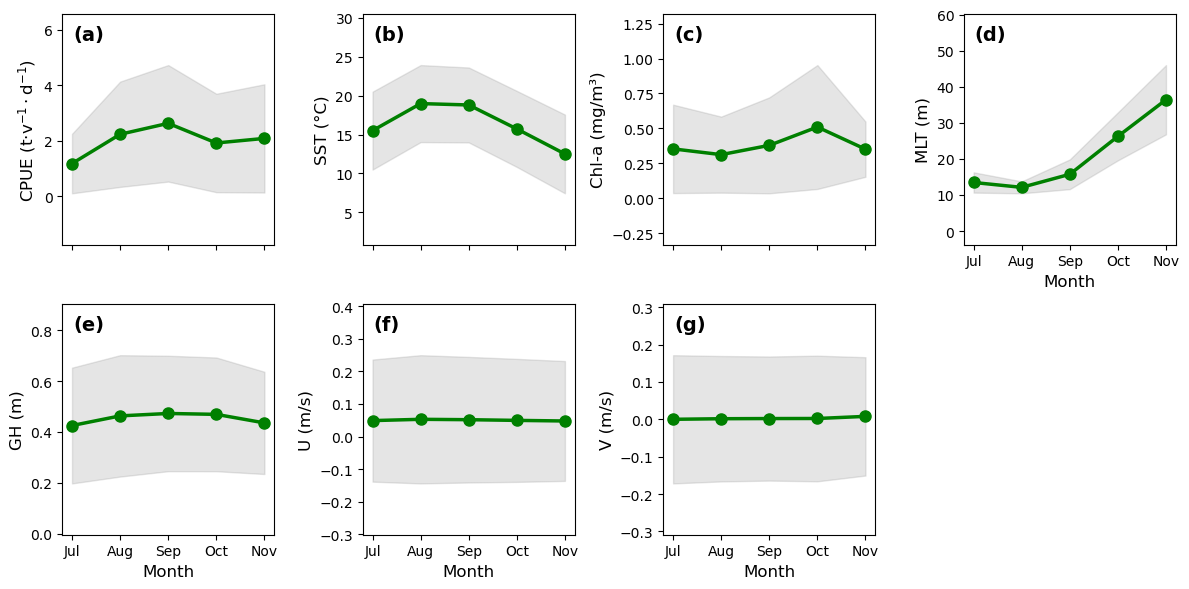

In [ ]:
# Figure S4: Seasonal Trends of Environmental Factors and CPUE
import matplotlib.dates as mdates

df_env['Date_dt'] = pd.to_datetime(df_env['Date'])
df_env['Month'] = df_env['Date_dt'].dt.month

# Aggregate monthly statistics across years
monthly_stats = df_env.groupby('Month').agg({
    'SST': ['mean', 'std'], 'Chl-a': ['mean', 'std'],
    'MLT': ['mean', 'std'], 'GH': ['mean', 'std'],
    'U': ['mean', 'std'], 'V': ['mean', 'std']
}).reset_index()

monthly_stats.columns = ['Month', 'SST_mean', 'SST_std', 'Chl-a_mean', 'Chl-a_std',
                        'MLT_mean', 'MLT_std', 'GH_mean', 'GH_std',
                        'U_mean', 'U_std', 'V_mean', 'V_std']

Fishery_Env['Date_dt'] = pd.to_datetime(Fishery_Env['Date'])
Fishery_Env['Month'] = Fishery_Env['Date_dt'].dt.month

cpue_stats = Fishery_Env.groupby('Month')['CPUE'].agg(['mean', 'std']).reset_index()
cpue_stats.columns = ['Month', 'CPUE_mean', 'CPUE_std']

monthly_data = monthly_stats.merge(cpue_stats, on='Month', how='left')

variables = ['CPUE', 'SST', 'Chl-a', 'MLT', 'GH', 'U', 'V']
units = [r't$\cdot$v$^{-1}\cdot$d$^{-1}$', '°C', 'mg/m³', 'm', 'm', 'm/s', 'm/s']
subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)']

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True)
axes_flat = axes.flatten()

for idx, (var, unit) in enumerate(zip(variables, units)):
    ax = axes_flat[idx]
    mean_val, std_val = monthly_data[f'{var}_mean'], monthly_data[f'{var}_std']
    
    ax.plot(monthly_data['Month'], mean_val, marker='o', color='green', linewidth=2.5, markersize=8)
    ax.fill_between(monthly_data['Month'], mean_val - std_val, mean_val + std_val, color='gray', alpha=0.2)
    
    ax.set_ylabel(f'{var} ({unit})', fontsize=12)
    ax.text(0.05, 0.95, subplot_labels[idx], transform=ax.transAxes, fontsize=14, fontweight='bold', va='top')
    
    # Calculate padding for ylim
    y_min, y_max = (mean_val - std_val).min(), (mean_val + std_val).max()
    pad = (y_max - y_min) * 0.4
    ax.set_ylim(y_min - pad, y_max + pad)

    # Show X-label and tick labels for subplot (d) and the bottom row
    if idx >= 3:
        ax.set_xlabel('Month', fontsize=12)
        ax.tick_params(labelbottom=True)

# Final formatting
for ax in axes_flat:
    ax.set_xticks([7, 8, 9, 10, 11])
    ax.set_xticklabels(['Jul', 'Aug', 'Sep', 'Oct', 'Nov'])

axes_flat[7].set_visible(False)  # Hide empty subplot

plt.tight_layout()
plt.savefig("./Figure/Figure_S4.pdf", bbox_inches="tight")
plt.savefig("./Figure/Figure_S4.png", format="png", dpi=600, bbox_inches="tight")

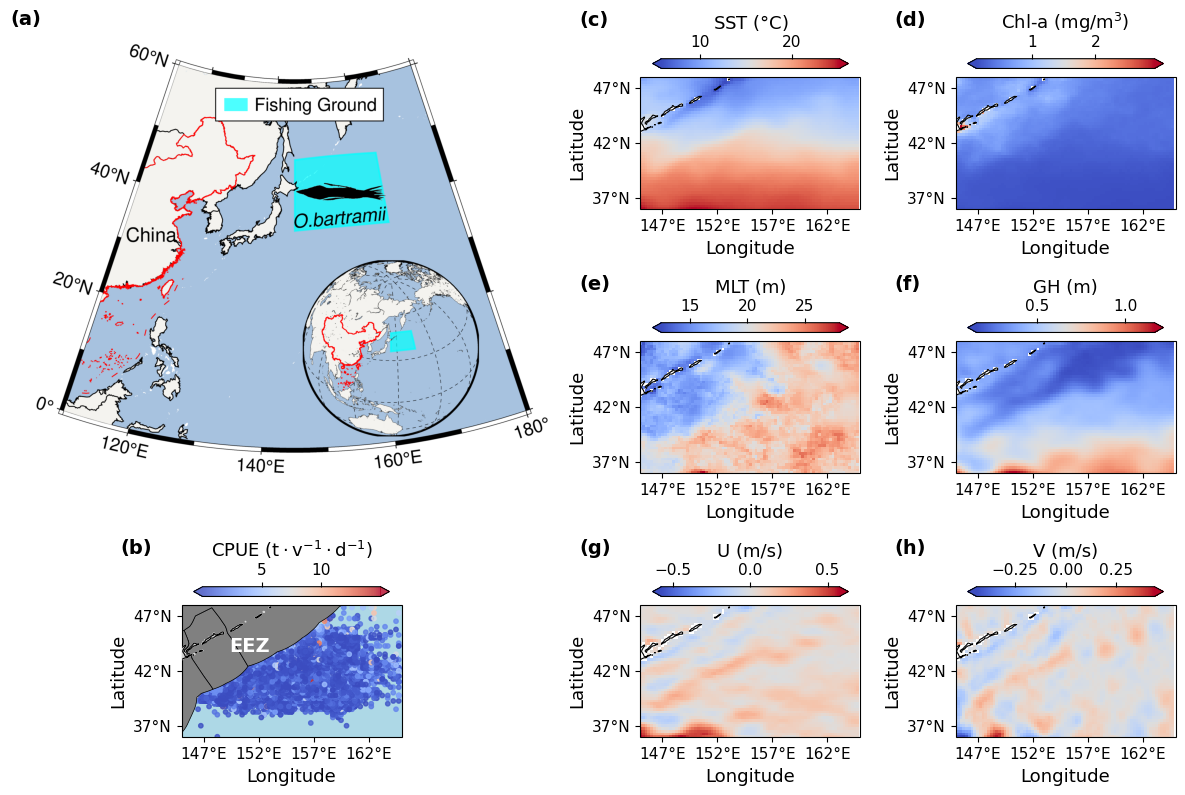

In [ ]:
# Figure 2: Study Area and Multi-Environmental Variable Maps
ds_mean_sst = ds_sst025['SST'].mean(dim='time')
ds_mean_chl = ds_chl025['CHL'].mean(dim='time')
ds_mean_mlt = ds_multi025['MLT'].mean(dim='time')
ds_mean_gh = ds_multi025['GH'].mean(dim='time')
ds_mean_u = ds_multi025['U'].mean(dim='time')
ds_mean_v = ds_multi025['V'].mean(dim='time')

Cbar_list = [r'SST $(\mathrm{°C})$', r'Chl-a $(\mathrm{mg}/\mathrm{m}^3)$', r'CPUE $(\mathrm{t}\cdot\mathrm{v}^{-1}\cdot\mathrm{d}^{-1})$']
eez_shp = gpd.read_file('./GMT_EEZ/EEZ_land_union_v4_202410/EEZ_land_union_v4_202410.shp')

# --- 1. Generate PyGMT Study Area Map ---
fig_gmt = pygmt.Figure()
pygmt.config(FONT_ANNOT_PRIMARY="11p,Helvetica,black")
fg_coords = [[145, 36], [165, 36], [165, 48], [145, 48], [145, 36]]

fig_gmt.coast(region=[110, 180, 0, 60], projection="L145/42/0/60/10c", 
              frame=["a20f10", "x+lLongitude", "y+lLatitude"], water="167/194/223")
fig_gmt.plot(data=fg_coords, pen="1p,cyan@30", fill="cyan@30")
fig_gmt.coast(land="244/243/239", shorelines="1/0.5p", borders="1/0.5p", area_thresh=10000)
fig_gmt.plot(data="./GMT_EEZ/CN-border-L1.gmt", pen="0.5p,red")
fig_gmt.text(x=115.5, y=32, text="China", font="12p,Helvetica,black")
fig_gmt.text(x=154.5, y=38, text="O.bartramii", font="11.5p,Helvetica-Oblique,black", angle=5)
fig_gmt.image(imagefile="./GMT_EEZ/O.bartramii_mask.png", position="g145/40.4+w-2.0")
fig_gmt.legend(spec="./GMT_EEZ/legend.txt", position="jTC+o0.1c/0.5c", box="+gwhite+p0.5p")

with fig_gmt.inset(position="jBR+w1.5i+o0.4i/0.1i"):
    pygmt.config(MAP_GRID_PEN_PRIMARY="0.25p,black,2_2")
    fig_gmt.coast(projection="G145/38/1.5i", region="g", frame="g", water="167/194/223")
    fig_gmt.plot(data=[[145, 36, 165, 48]], style="r+s", pen="1p,cyan@30", fill="cyan@30")
    fig_gmt.coast(shorelines="faint", land="244/243/239")
    fig_gmt.plot(data="./GMT_EEZ/CN-border-L1.gmt", pen="0.5p,red")

tmp_gmt_img = "./GMT_EEZ/temp_gmt_plot.png"
fig_gmt.savefig(tmp_gmt_img, dpi=600)

# --- 2. Build Main Layout ---
fig = plt.figure(figsize=(15, 9))
gs = fig.add_gridspec(3, 5, hspace=0.6, wspace=0.4, width_ratios=[0.3, 1, 0.3, 1, 1])

# Subplot (a): Study Area
ax_map = fig.add_subplot(gs[0:2, 0:3])
ax_map.imshow(mpimg.imread(tmp_gmt_img)); ax_map.axis('off')
ax_map.text(-0.05, 1.08, '(a)', transform=ax_map.transAxes, fontsize=14, fontweight='bold', va='top')

# Create subplots
ax_sst = fig.add_subplot(gs[0, 3], projection=ccrs.PlateCarree())
ax_chl = fig.add_subplot(gs[0, 4], projection=ccrs.PlateCarree())
ax_mlt = fig.add_subplot(gs[1, 3], projection=ccrs.PlateCarree())
ax_gh = fig.add_subplot(gs[1, 4], projection=ccrs.PlateCarree())
ax_cpue = fig.add_subplot(gs[2, 1], projection=ccrs.PlateCarree())
ax_u = fig.add_subplot(gs[2, 3], projection=ccrs.PlateCarree())
ax_v = fig.add_subplot(gs[2, 4], projection=ccrs.PlateCarree())

def setup_map(ax, title_tag):
    ax.coastlines(resolution='50m', color='black', linewidth=0.8, zorder=10)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_min+2, lon_max, 5), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_min+1, lat_max, 5), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.tick_params(axis='both', which='major', labelsize=11)
    ax.set_xlabel('Longitude', fontsize=13)
    ax.set_ylabel('Latitude', fontsize=13)
    ax.text(-0.28, 1.5, title_tag, transform=ax.transAxes, fontsize=14, fontweight='bold', va='top')

# Plot env variables (c-h)
for ax, data, label, tag in zip([ax_sst, ax_chl, ax_mlt, ax_gh, ax_u, ax_v], 
                                [ds_mean_sst, ds_mean_chl, ds_mean_mlt, ds_mean_gh, ds_mean_u, ds_mean_v],
                                [Cbar_list[0], Cbar_list[1], 'MLT (m)', 'GH (m)', 'U (m/s)', 'V (m/s)'],
                                ['(c)', '(d)', '(e)', '(f)', '(g)', '(h)']):
    im = data.plot(ax=ax, cmap='coolwarm', transform=ccrs.PlateCarree(), add_colorbar=False, extend='both')
    cbar = plt.colorbar(im, ax=ax, location='top', pad=0.05, label=label, shrink=0.8, extend='both')
    cbar.ax.xaxis.label.set_size(13)
    cbar.ax.tick_params(labelsize=11)
    setup_map(ax, tag); ax.set_title('')

# Plot CPUE Map (b)
ax_cpue.add_feature(cfeature.OCEAN, color='lightblue', zorder=0)
sc = ax_cpue.scatter(Fishery_Env.Lon, Fishery_Env.Lat, c=Fishery_Env.CPUE, 
                    cmap='coolwarm', s=10, alpha=0.8, transform=ccrs.PlateCarree(), zorder=1)
eez_shp.plot(ax=ax_cpue, alpha=1.0, edgecolor='black', facecolor='grey', linewidth=0.5, transform=ccrs.PlateCarree(), zorder=2)
ax_cpue.add_feature(cfeature.LAND, color='lightgray', zorder=3)
ax_cpue.add_feature(cfeature.BORDERS, linewidth=0.3, zorder=4)

cbar_cpue = plt.colorbar(sc, ax=ax_cpue, location='top', pad=0.05, label=Cbar_list[2], shrink=0.8, extend='both')
cbar_cpue.ax.xaxis.label.set_size(13)
cbar_cpue.ax.tick_params(labelsize=11)
ax_cpue.text(0.4, 0.65, 'EEZ', transform=ax_cpue.transAxes, color='white', ha='right', fontsize=14, fontweight='bold')
setup_map(ax_cpue, '(b)')

if os.path.exists(tmp_gmt_img): os.remove(tmp_gmt_img)

plt.savefig("./Figure/Figure_2.pdf", bbox_inches="tight")
plt.savefig("./Figure/Figure_2.png", format="png", dpi=600, bbox_inches="tight")